In [ ]:
!apt-get install -q -y build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip3 install auto-sklearn

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

from sklearn.utils.testing import ignore_warnings

import sklearn.model_selection
# import autosklearn.classification

sns.set_style("whitegrid")

%matplotlib inline



In [27]:
df = pd.read_csv("../input/insurance.csv")

**Data Transformations**
* Turn ages into groups
* Turn BMIs into groups
* Convert Percents 

In [ ]:
# Code in this cell is taken from Rishabh Pande's kernel, link - https://www.kaggle.com/rishpande/pandas-simple-tutorial-refresher

def percConvert(ser):
    return ser/float(ser[-1])

pd.crosstab(df["sex"],df["region"],margins=True).apply(percConvert, axis=1)

In [29]:
# Code in this cell is inspired by Jeff Delaney's kernel, link - https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish/notebook

def simplify_ages(data):
    bins = (15, 20, 30, 40, 50, 60, 70)
    group_names = ['Teenager', 'Twenties', 'Thirties', 'Fourties', 'Fifties', 'Sixities']
    categories = pd.cut(data.age, bins, labels=group_names)
    data.age = categories
    return data
  
def simplify_bmi(data):
    bins = (15, 25, 35, 45, 60)
    group_names = ['Small', 'Medium', 'Big', 'vBig']
    categories = pd.cut(data.bmi, bins, labels=group_names)
    df.bmi = categories
    return data
  
def transform_features(data):
    if df.age.dtypes == int:
        data = simplify_ages(data)
    if df.bmi.dtypes == float:
        data = simplify_bmi(data)
    return data

df = transform_features(df)

**Distributions of Medical Charges**

The charges are **right skewed distributed** where most patients are charged between 2,000 - 12,000 



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


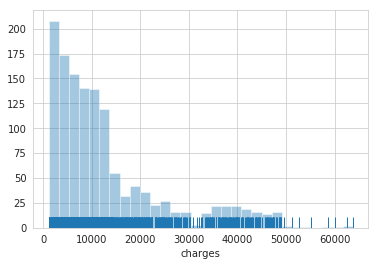

In [24]:
 sns.distplot(df['charges'],kde=False,rug=True);

**Correlation Matrix**

As we can see below on the correlation matrix, there is a strong correlation between smoking and charges paid patients pay.

In [ ]:
# adopted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html

cor_matx = df_t.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(cor_matx, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_matx,  cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


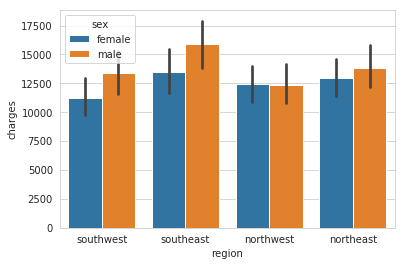

In [7]:
sns.barplot(x="region", y="charges", hue="sex", data=df);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


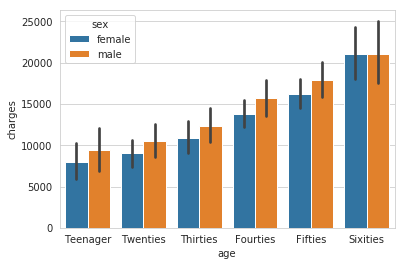

In [8]:
sns.barplot(x="age", y="charges", hue="sex", data=df)

**Is there a relationship between charges and BMI?**

There seems to be a strong positive correlation between BMI and Charges paid by patients.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


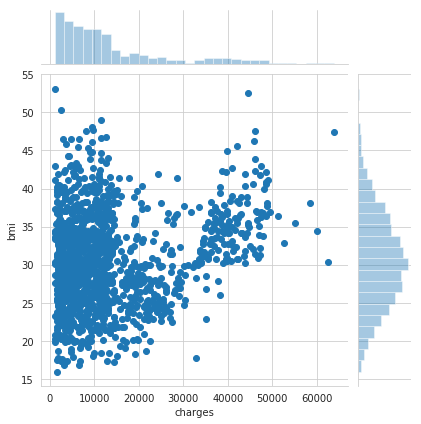

In [28]:
sns.jointplot(x=df['charges'],y=df['bmi'],data=df)

There seems to be a strong relationship between charges and smoking. Let's take a closer look

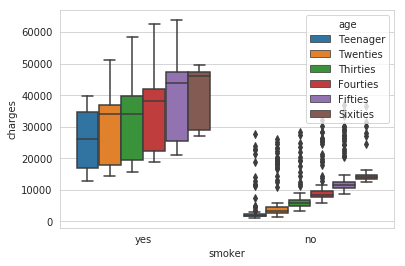

In [10]:
sns.boxplot(x="smoker",y="charges",hue="age",data=df)

**Correlation between BMI, Smokers and Charges patients pay**

The separation between smokers and non-smokers interms of their charge is greater as their BMI increases

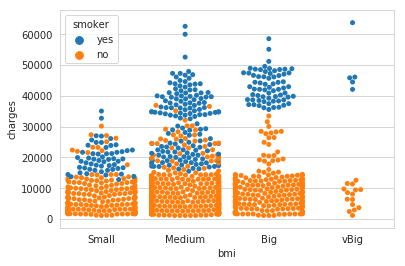

In [11]:
sns.swarmplot(x="bmi",y="charges",hue="smoker",data=df)

**Correlation between region, number of children and charges**

To our surprize as number of children increases, the premium they pay decreases.

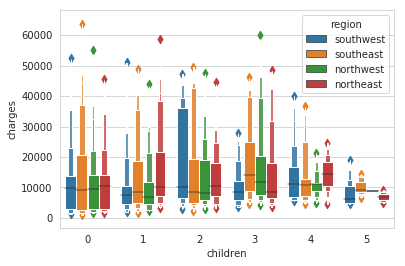

In [12]:
sns.boxenplot(x="children",y="charges", hue="region",data=df)

**Correlatiob between Sex, Charges and smoking**

The distribution between sex and charges seems to be quite similar for box sexes. There isn't much discrepancy. THe only difference being, male patients tend to pay slightly higher.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


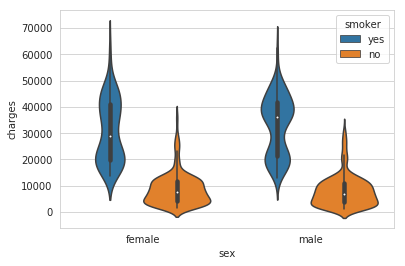

In [22]:
sns.violinplot(x="sex",y="charges",hue="smoker",data=df)

**Correlation between charges and patient's number of children for smokers and non smokers**




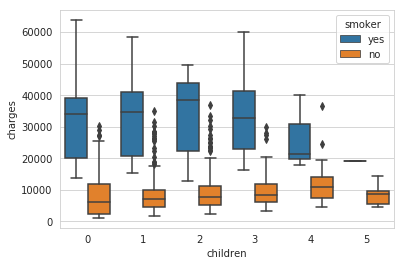

In [21]:
sns.boxplot(x="children",y="charges",hue="smoker",data=df)

In [ ]:
# Code in this cell is inspired by Jeff Delaney's kernel, link - https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish/notebook
# Todo may be do some DictVectorizer transformation (for age, bmi, children, region), like this link - https://stackoverflow.com/questions/33008644/onehotencoder-with-string-categorical-values
# but have to know what do next if you can figure that out then using this should not be a problem


from sklearn import preprocessing
def encode_features(data):
    features = ['age', 'sex', 'bmi', 'smoker', 'region']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data
    
df = encode_features(df)
df.head()

**Feature Engineering**

Add *Approved* column based on ...

In [ ]:
df['approved'] = 0
df['approved'] = np.where(df['charges'] < 16639.912515, 1, 0)
df.head()

**Split data into train and test** 

In [ ]:
# Code in this cell is inspired by Jeff Delaney's kernel, link - https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish/notebook

from sklearn.model_selection import train_test_split

X_all = df.drop(['approved','charges'], axis=1)
y_all = df['approved']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=12)

y_train.head()

In [ ]:
# Code in this following three cells is inspired by Jeff Delaney's kernel, link - https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish/notebook

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=10, iid=False)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))

#! Confusion Matrix
labels = [1, 0]
cm = confusion_matrix(y_test, predictions, labels)

rfc_y_pred = predictions
rfc_fpr, rfc_tpr, thresholds = metrics.roc_curve(y_test, rfc_y_pred)
print("AUC: ", metrics.auc(rfc_fpr, rfc_tpr))

In [ ]:
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

In [ ]:
#Code from : http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-ix-bias-variance-and-learning-curves

def draw_learning_curve(train_sizes, train_scores, validation_scores, title):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim((0.6, 1.01))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.gca().invert_yaxis()
    plt.grid()

    # Plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha=0.1, color="b")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, 
                     alpha=0.1, color="r")

    # Plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="r", label="Validation score")

    plt.legend(loc="best")

    # Draw the plot and reset the y-axis
    # plt.draw()
    plt.grid()
    plt.show()
    
    
train_sizes, train_scores, validation_scores = learning_curve(
            clf, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
    
draw_learning_curve(train_sizes, train_scores, validation_scores, "RandomForestClassifierLearningRate")


In [ ]:
#prepare dataset for NN training and validation
num_valid = 0.20
nn_X_train, nn_X_valid, nn_y_train, nn_y_valid = train_test_split(X_train, y_train, test_size=num_valid, random_state=12)

In [ ]:
epochs = 50;
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation=tf.nn.relu, input_shape=[len(nn_X_train.keys())]),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy']
             )

big_history = model.fit(nn_X_train, nn_y_train, epochs=epochs, validation_data=(nn_X_valid, nn_y_valid), verbose=0)
a = model.evaluate(X_test, y_test)
print("Accuracy: ", a[1])

nn_y_pred = model.predict(X_test)

nn_fpr, nn_tpr, thresholds = metrics.roc_curve(y_test, nn_y_pred)
print("AUC: ", metrics.auc(nn_fpr, nn_tpr))

In [ ]:
epochs = 50;
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, activation=tf.nn.relu, input_shape=[len(nn_X_train.keys())]),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy']
             )

small_history = model.fit(nn_X_train, nn_y_train, epochs=epochs, validation_data=(nn_X_valid, nn_y_valid), verbose=0)
a = model.evaluate(X_test, y_test)
print("Accuracy: ", a[1])

nn_y_pred = model.predict(X_test)

nn_fpr, nn_tpr, thresholds = metrics.roc_curve(y_test, nn_y_pred)
print("AUC: ", metrics.auc(nn_fpr, nn_tpr))

In [ ]:
epochs = 50;
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, activation=tf.nn.relu, input_shape=[len(nn_X_train.keys())]),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', 'mean_squared_error']
             )

mse_history = model.fit(nn_X_train, nn_y_train, epochs=epochs, validation_data=(nn_X_valid, nn_y_valid), verbose=0)
a = model.evaluate(X_test, y_test)
print("Accuracy: ", a[1])

nn_y_pred = model.predict(X_test)

nn_fpr, nn_tpr, thresholds = metrics.roc_curve(y_test, nn_y_pred)
print("AUC: ", metrics.auc(nn_fpr, nn_tpr))

In [ ]:
def plot_history(histories):
  plt.figure(figsize=(16,10))
    
  for name, history, key in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()



  plt.xlim([0,max(history.epoch)])

plot_history([('baseline', small_history, 'binary_crossentropy'), ('bigger', big_history, 'binary_crossentropy'), ('mse', mse_history, 'mean_squared_error')])



In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)

svc_y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, svc_y_pred).ravel()
print("Accuracy: ", ((tn + tp)/(tn + fp + fn + tp)))

svc_fpr, svc_tpr, thresholds = metrics.roc_curve(y_test, svc_y_pred)
print("AUC: ", metrics.auc(svc_fpr, svc_tpr))

In [ ]:
def draw_validation_curve(train_scores_knn, test_scores_knn, param_range, title, label):
    train_scores_knn_mean = np.mean(train_scores_knn, axis=1)
    train_scores_knn_std = np.std(train_scores_knn, axis=1)
    test_scores_knn_mean = np.mean(test_scores_knn, axis=1)
    test_scores_knn_std = np.std(test_scores_knn, axis=1)

    plt.title(title)
    plt.xlabel(label)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_knn_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_knn_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

param_range = ["linear", "poly", "rbf", "sigmoid"]

train_scores_knn, test_scores_knn = validation_curve(
    svm.SVC(), X_train, y_train, param_name="kernel", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

draw_validation_curve(train_scores_knn, test_scores_knn, param_range, "Validation Curve with SVC", "kernel")

In [ ]:
#Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    svm.SVC(), X_train, y_train, train_sizes=np.linspace(.1, 1., 10), cv=10)
draw_learning_curve(train_sizes, train_scores, valid_scores, "SVC Classifier Learning Rate")

In [ ]:
gnb = GaussianNB()
gnb_y_pred = gnb.fit(X_train, y_train).predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, gnb_y_pred).ravel()
print("Accuracy: ", ((tn + tp)/(tn + fp + fn + tp)))

gnb_fpr, gnb_tpr, thresholds = metrics.roc_curve(y_test, gnb_y_pred)
print("AUC: ", metrics.auc(gnb_fpr, gnb_tpr))

In [ ]:
#Learning Curve
train_sizes_gnb, train_scores_gnb, valid_scores_gnb = learning_curve(
        gnb, X_train, y_train, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
    
draw_learning_curve(train_sizes_gnb, train_scores_gnb, valid_scores_gnb, "Gaussian NB Classifier Learning Rate")


In [ ]:

neigh = KNeighborsClassifier(n_neighbors=6)

neigh.fit(X_train, y_train)

knc_y_pred = neigh.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, knc_y_pred).ravel()
print("Accuracy: ", ((tn + tp)/(tn + fp + fn + tp)))

knc_fpr, knc_tpr, thresholds = metrics.roc_curve(y_test, knc_y_pred)
print("AUC: ", metrics.auc(knc_fpr, knc_tpr))


In [ ]:
param_range = np.arange(1, 20, 1)

train_scores_knn, test_scores_knn = validation_curve(
    neigh, X_train, y_train, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

draw_validation_curve(train_scores_knn, test_scores_knn, param_range, "Validation Curve with KNN", "n_neighbors")


In [ ]:
#Learning Curve
train_sizes_knn, train_scores_knn, valid_scores_knn = learning_curve(
       KNeighborsClassifier(n_neighbors=4), X_train, y_train, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
  
draw_learning_curve(train_sizes_knn, train_scores_knn, valid_scores_knn, "KNN Classifier Learning Curve")

In [ ]:
train_sizes_knn, train_scores_knn, valid_scores_knn = learning_curve(
        KNeighborsClassifier(n_neighbors=6), X_train, y_train, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
    
draw_learning_curve(train_sizes_knn, train_scores_knn, valid_scores_knn, "KNN Classifier Learning Rate")


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#SVC
ax.plot(svc_fpr, svc_tpr, color='tab:blue')
#Gaussian Naive Bayes
ax.plot(gnb_fpr, gnb_tpr, color='tab:orange')
#K-Nearest Classification
ax.plot(knc_fpr, knc_tpr, color='tab:green')
#Neural Network
ax.plot(nn_fpr, nn_tpr, color='tab:red')
#Random Forest Classification
ax.plot(rfc_fpr, rfc_tpr, color='tab:purple')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.set_title('ROC curves')
plt.show()

In [ ]:
# The following code is taken from - https://automl.github.io/auto-sklearn/master/

X_all = df.drop(['approved','charges'], axis=1)
y_all = df['approved']

XA_train, XA_test, ya_train, ya_test = sklearn.model_selection.train_test_split(X_all, y_all, random_state=12)

ya_train.head()


In [ ]:
# with ignore_warnings(category=RuntimeWarning):
#     automl = autosklearn.classification.AutoSklearnClassifier()
#     automl.fit(XA_train, ya_train)
#     y_hat = automl.predict(XA_test)
#     print("Accuracy score", sklearn.metrics.accuracy_score(ya_test, y_hat))